# Super resolution on medical images:

## Set-up:

##### Imports:

In [29]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
import tensorflow as tf
from torchvision.models import vgg16_bn
import torchvision.transforms as transforms
from skimage import measure

from  modified_model_fx import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
trans1 = transforms.ToTensor()
trans = transforms.ToPILImage()

Set CUDA: 

In [4]:
torch.cuda.set_device(3)

### Import data: 

Input images:
- HR images: **(3, 502, 672)** original (3, 1004, 1344) cut in 4 pieces
- LR images: **(3, 250, 334)** original (3, 500, 669) cut in 4 pieces

Paths to data:


In [5]:
path = Path('../../../../../SCRATCH2/marvande/data/train/HR/')

# path to HR data:
path_hr = path / 'HR_patches_train/jpg_images'

# path where we create the LR data:
path_lr = path / 'small-250/train'

# path to MR data (of same size as HR):
path_mr = path / 'small-502/train'

# path to original LR data:
path_lr_or = path/'HR_patches_resized/jpg_images'

assert path.exists(), f"need dataset @ {path}"
assert path_hr.exists()

Have a look at what type of data is in those folders. First, we look at our HR images from `path_hr`. 

In [6]:
il = ImageList.from_folder(path_hr)
ImageList.from_folder(path_hr)

ImageList (6168 items)
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/HR_patches_train/jpg_images

### Create LR and MR data:

From this HR data, we create LR versions in `path_lr` and `path_mr` for training. LR images will be of size `(3, 250, 334)` while MR images of the same size as the HR but of lower quality (MR images are used in the second phase of training), thus `(3, 502, 672)`. 

In [31]:
def resize_one(fn, i, path, size):
    """resize_one: resizes images to input size and saves them in path, 
    quality is lowered as to get LR images. 
    
    """
    dest = path / fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    img = img.resize(size, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [8]:
# create smaller image sets the first time this nb is run:
sets = [(path_lr, (334, 250)), (path_mr, (672, 502))]
for p, size in sets:
    if not p.exists():
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

Have a look at the new LR and MR images and their sizes.

In [33]:
print('LR:')
print(ImageList.from_folder(path_lr))
print('MR:')
print(ImageList.from_folder(path_mr))

LR:
ImageList (6168 items)
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train
MR:
ImageList (6168 items)
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-502/train


#### Training and validation data:

As the model's first phase is on images of the LR size, we create the first batch of training data of size `(3, 250, 334)`. So HR images are downsized to `(3, 250, 334)` and both HR and LR are transformed using several transformations (see `modified_model_fx.py`). Those data augmentation techniques help avoid overfitting during training.

In [11]:
# set image size and batch size to which data is transformed:
bs, size = 15, (250, 334)
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [35]:
def get_data(bs, size):
    """
    get_data: creates training and validation data from LR and HR. 
    downsizes HR to LR size and applies transformations to both. 
    """

    #label_from_func: apply func to every input to get its label.
    # defining a custom function to extract the labels
    data = src.label_from_func(lambda x: path_hr / x.relative_to(path_lr))

    #apply data transformations,
    data = data.transform(tfms, size=size, 
                          tfm_y=True).databunch(bs=bs).normalize(imagenet_stats,
                                                                do_y=True)
    data.c = 3
    return data

In [36]:
data = get_data(bs, size)
data

ImageDataBunch;

Train: LabelList (5552 items)
x: ImageImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
y: ImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train;

Valid: LabelList (616 items)
x: ImageImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
y: ImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train;

Test: None

Have a look at a few data from the validation data. Left are the LR while right the corresponding Hr images. 

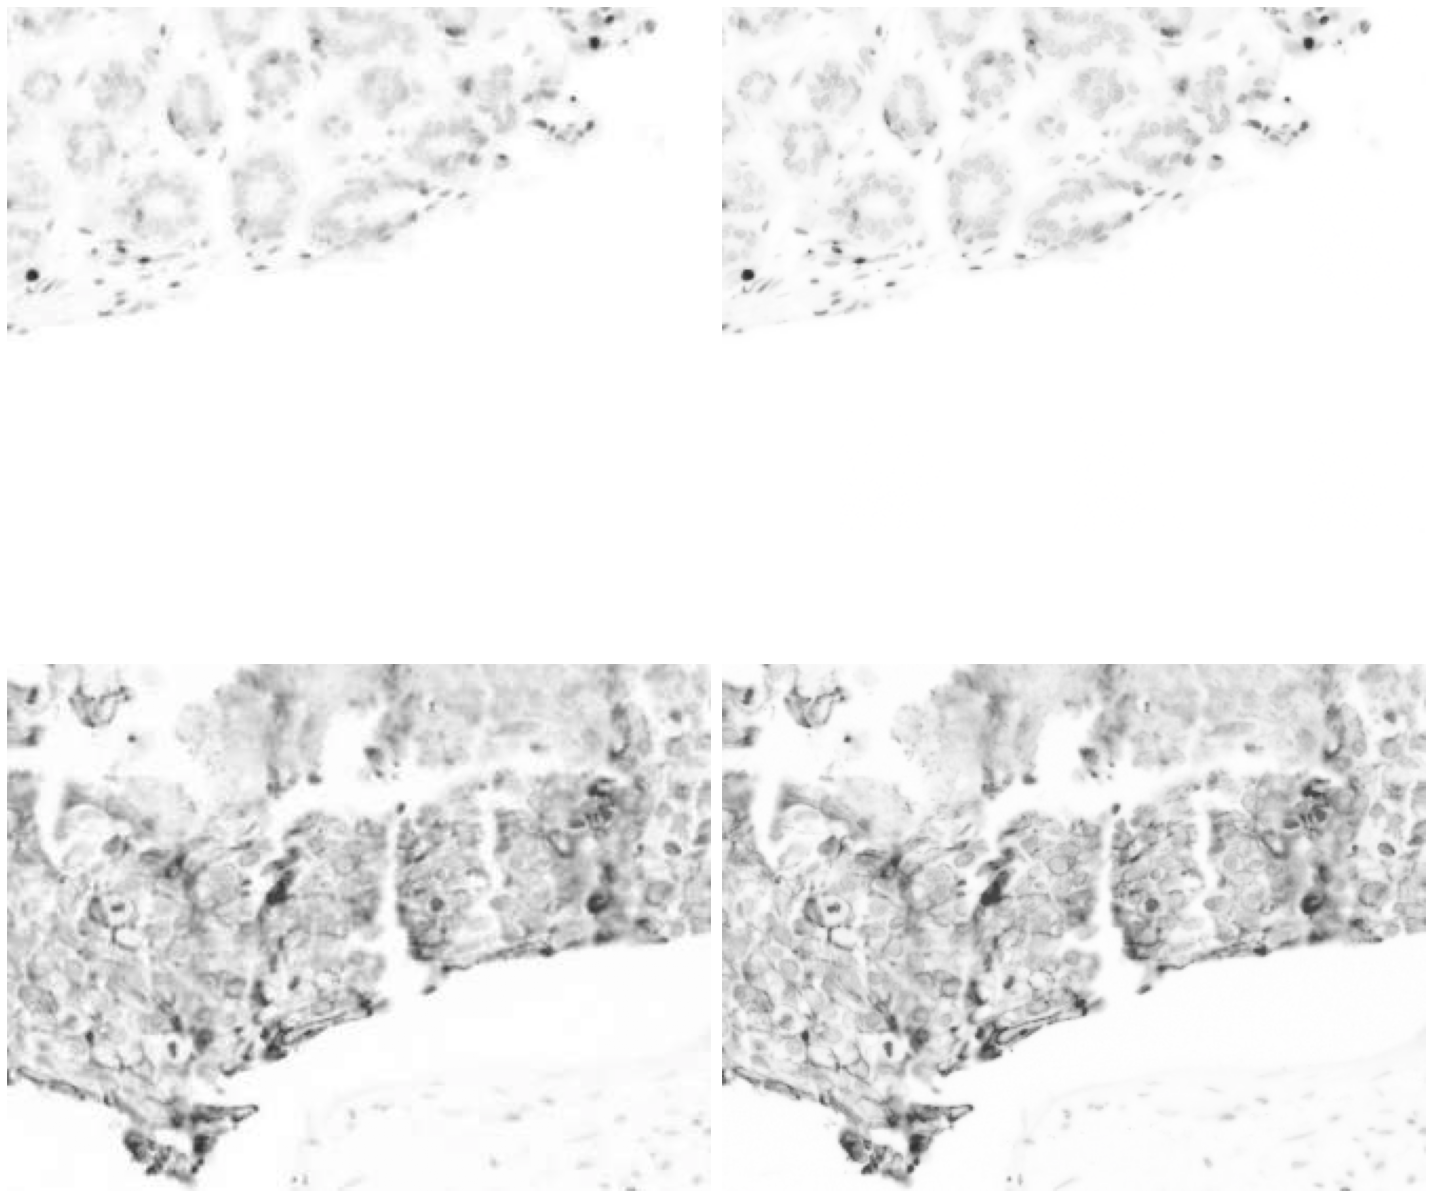

In [16]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(20, 20))

## Feature loss: 
Create loss metrics used in the model. 

In [43]:
def gram_matrix(x):
    """
    Gram matrix of a set of vectors in an inner 
    product space is the Hermitian matrix of inner products
    """
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

Select the data of an image and use it to compute its Gram matrix. 

In [44]:
im = data.valid_ds[0][1]
t = im.data
t = torch.stack([t,t])

In [45]:
gram_matrix(t)

tensor([[[0.3176, 0.3176, 0.3176],
         [0.3176, 0.3176, 0.3176],
         [0.3176, 0.3176, 0.3176]],

        [[0.3176, 0.3176, 0.3176],
         [0.3176, 0.3176, 0.3176],
         [0.3176, 0.3176, 0.3176]]])

We define a base loss as the L1 loss (`F.l1_loss`). 

In [38]:
base_loss = F.l1_loss

Construct a pre-trained `vgg16` model ([Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)). VGG is another Convolutional Neural Network (CNN) architecture devised in 2014, the 16 layer version is utilised in the loss function for training this model. VGG model. a network pretrained on ImageNet, is used to evaluate the generator model’s loss.


Further, we set `requires_grad` to `False` as this is useful when you want to freeze part of your model, or you know in advance that you are not going to use gradients w.r.t. some parameters. 

<img src = 'images/vgg16-1-e1542731207177.png'>


The head of the VGG model is the final layers shown as fully connected and softmax in the above diagram. This head is ignored and the loss function uses the intermediate activations in the backbone of the network, which represent the feature detections.

<img src = 'images/0_3oRr_BjTm49I8qge.png'>

Those activations can be found by looking through the VGG model to find all the max pooling layers. These are where the grid size changes and features are detected. So we need to select those layers.

In [54]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Select the layer IDs of `MaxPool2d` blocks:

In [40]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

Create the feature loss from the model and layer ids selected above. 

Source: 
- [Article 1](https://towardsdatascience.com/loss-functions-based-on-feature-activation-and-style-loss-2f0b72fd32a9)
- [Article 2](https://towardsdatascience.com/deep-learning-based-super-resolution-without-using-a-gan-11c9bb5b6cd5)

Main points:
- Loss functions using these techniques can be used during the training of U-Net based model architectures
- Feature loss: loss function used is similar to the loss function in the the [paper](https://arxiv.org/abs/1603.08155), using VGG-16 but also combined with pixel mean squared error loss loss and gram matrix style loss
- The training of a model can use this loss function based on the VGG model’s activations. The loss function remains fixed throughout the training unlike the critic part of a GAN
- Feature loss:  Feature map has 256 channels by 28 by 28. The activations at the same layer for the (target) original image and the generated image are compared using mean squared error or the least absolute error (L1) error for the base loss. These are feature losses. This error function uses L1 error. This allows the loss function to know what features are in the target ground truth image and to evaluate how well the model’s prediction’s features match these rather than only comparing pixel difference. This allows the model being trained with this loss function to produce much finer detail in the generated/predicted features and output.
- Gram matrix style loss: A gram matrix defines a style with respect to specific content. By calculating the gram matrix for each feature activation in the target/ground truth image, it allows the style of that feature to be defined. If the same gram matrix is calculated from the activations of the predictions, the two can be compared to calculate how close the style of the feature prediction is to the target/ground truth image. A gram matrix is the matrix multiplication of the each of the activations and the activation matrix’s transpose. This enables the model to learn and generate predictions of images whose features look correct in their style and in context, with the end result looking more convincing and appear closer or the same as the target/ground truth.


**Predictions from models trained with this loss function:** The generated predictions from trained models using loss functions based on these techniques have both convincing fine detail and style. That style and fine detail may be different aspects of image quality be predicting fine pixel detail or the predicting correct colours.

In [41]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        #feat losses
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        #gram: 
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [42]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [26]:
#lr = 1e-3
lr = 1e-3
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=10)

In [51]:
# delete all tensors and free cache:
for obj in gc.get_objects():
    if torch.is_tensor(obj):
        del obj
torch.cuda.empty_cache()
gc.collect()
#learn.destroy()

#get free memory (in MBs) for the currently selected gpu id, after emptying the cache
print(
    'free memory (in MBs) for the currently selected gpu id, after emptying the cache: ',
    gpu_mem_get_free_no_cache())

print(
    'used memory (in MBs) for the currently selected gpu id, after emptying the cache:',
    gpu_mem_get_used_no_cache())

gpu_mem_get_all()

free memory (in MBs) for the currently selected gpu id, after emptying the cache:  11629
used memory (in MBs) for the currently selected gpu id, after emptying the cache: 583


[GPUMemory(total=12212, free=6920, used=5292),
 GPUMemory(total=12196, free=7717, used=4478),
 GPUMemory(total=12196, free=7183, used=5012),
 GPUMemory(total=12212, free=11629, used=583)]

In [52]:
wd = 1e-3
learn = unet_learner(data,
                     arch,
                     wd=wd,
                     loss_func=feat_loss,
                     callback_fns=LossMetrics,
                     blur=True,
                     norm_type=NormType.Weight)
# garbage collection:
gc.collect()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


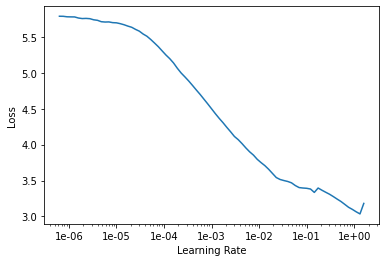

In [53]:
learn.lr_find()
learn.recorder.plot()

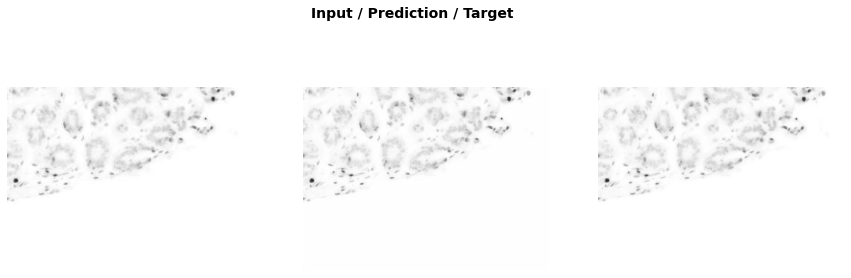

In [55]:
do_fit('1a_mod', slice(lr*10))

In [57]:
learn.unfreeze()

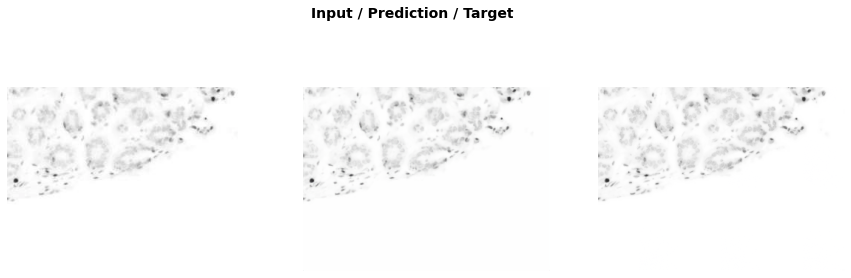

In [58]:
do_fit('1b_mod', slice(1e-5,lr))

Phase 2: 

In [27]:
torch.cuda.empty_cache()
gc.collect()
#learn.destroy()

#get free memory (in MBs) for the currently selected gpu id, after emptying the cache
print(
    'free memory (in MBs) for the currently selected gpu id, after emptying the cache: ',
    gpu_mem_get_free_no_cache())

print(
    'used memory (in MBs) for the currently selected gpu id, after emptying the cache:',
    gpu_mem_get_used_no_cache())

gpu_mem_get_all()

free memory (in MBs) for the currently selected gpu id, after emptying the cache:  10880
used memory (in MBs) for the currently selected gpu id, after emptying the cache: 1332


[GPUMemory(total=12212, free=9840, used=2372),
 GPUMemory(total=12196, free=7717, used=4478),
 GPUMemory(total=12196, free=10534, used=1661),
 GPUMemory(total=12212, free=10880, used=1332)]

In [28]:
new_size = (502, 672)
bs = 4
data = get_data(bs,new_size)

wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)

lr = 1e-3
# garbage collection: 
gc.collect();

In [29]:
learn.data = data
learn.freeze()
gc.collect()

20

In [30]:
data

ImageDataBunch;

Train: LabelList (5552 items)
x: ImageImageList
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
y: ImageList
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train;

Valid: LabelList (616 items)
x: ImageImageList
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
y: ImageList
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train;

Test: None

In [31]:
learn.load('1b_mod');

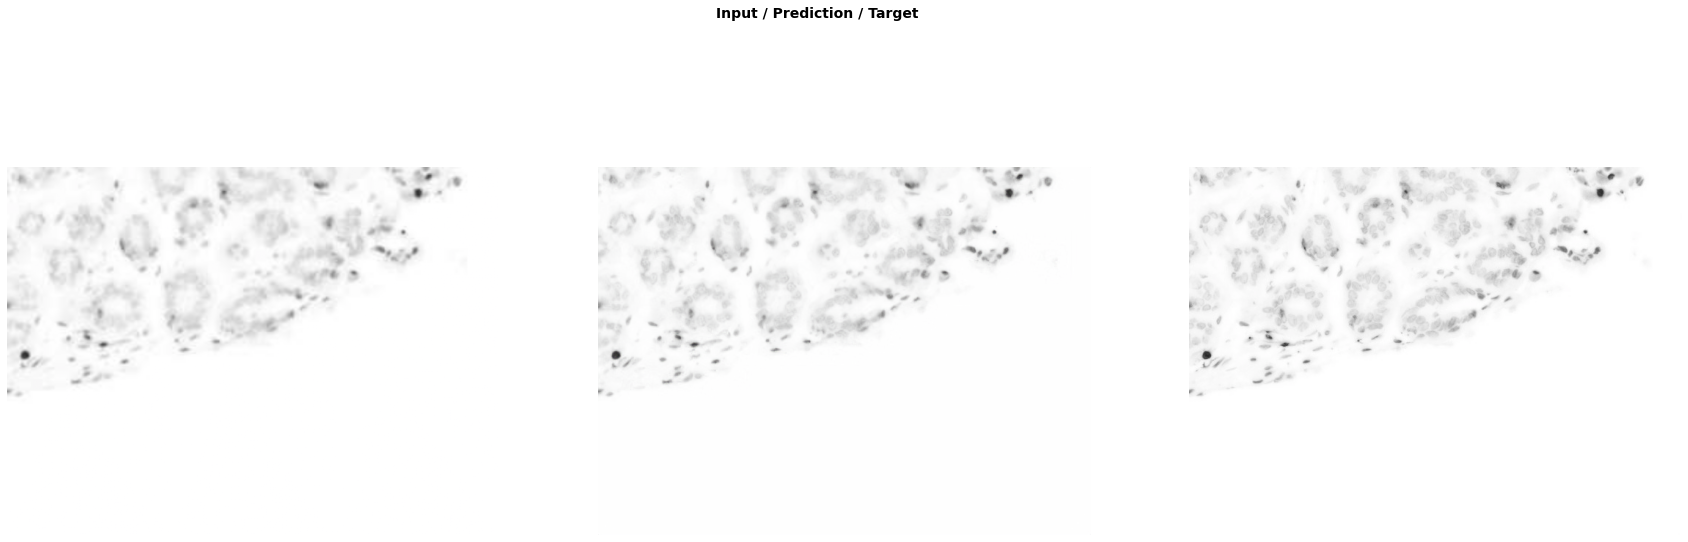

In [32]:
do_fit('2a_mod')

In [33]:
learn.unfreeze()

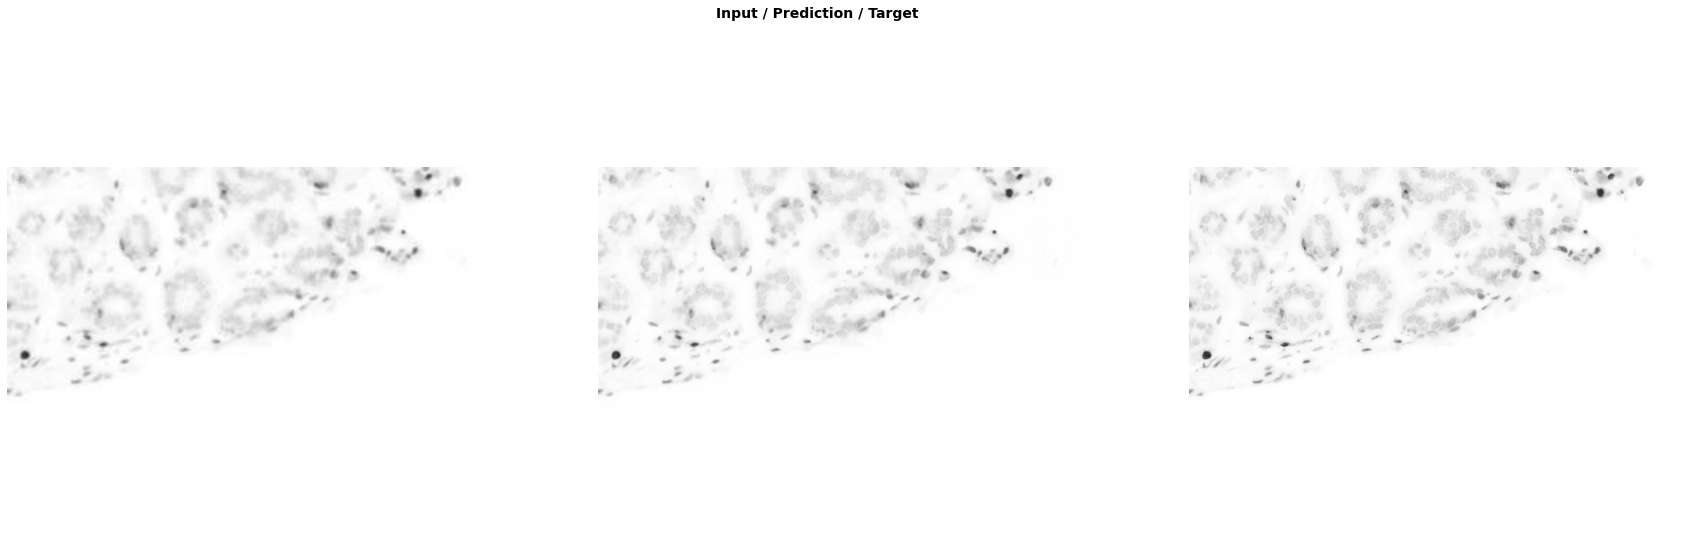

In [34]:
do_fit('2b_mod', slice(1e-6,1e-4), pct_start=0.3)

## Testing : 

Reconstruct the learn object, this time with l1_loss and not with feature_loss, **why?** 

In [17]:
learn = None
gc.collect()
learn = unet_learner(data,
                     arch,
                     loss_func=F.l1_loss,
                     blur=True,
                     norm_type=NormType.Weight)

##### Prediction:

Set the sizes of the LR input images (`size_lr`) for testing and the HR images (`size_mr`).

In [18]:
size_mr = (3, 502, 672)
size_lr = (3, 250, 334)

#Check free GPU RAM:
free = gpu_mem_get_free_no_cache()
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(250, 334), have 11411MB of GPU RAM free


Create testing data, `data_mr` of size HR and `data_lr` of size LR:

In [19]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(tfms, size=size_mr, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3
data_lr = (ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(tfms, size=size_lr, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_lr.c = 3

Load the learn object from the last phase (`2b_mod`) and set it's data to `data_mr` (**why?**).

In [20]:
learn.load('2b_mod')
learn.data = data_mr

Select the images we are going to use for testing from `data_mr` and `data_lr`: 

In [21]:
# Ground truth HR image:
gt_HR = data_mr.valid_ds.y.items[1]

# LR version of the same image:
lr = data_lr.valid_ds.x.items[1]

To be able to apply the model and predict the HR image from the LR, we need to resample the LR image to be of the same size as the HR, as the model inputs and outputs images of the same size. 

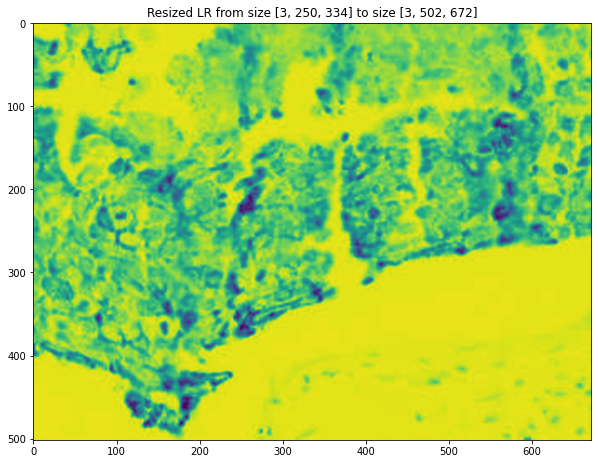

In [22]:
lr_data = open_image(lr)

# resample to same size as HR:
# for pytorch, have to add a first new dimension to indicate bs = 1
# now lr_data of shape [1, 3, 250, 334]
lr_data = lr_data.data.unsqueeze(0)
lr_resized = torch.nn.functional.interpolate(lr_data, size_mr[1:],
                                             mode='bicubic')
# remove the previous added dimension
lr_resized = lr_resized.squeeze()

# plot resized LR: 
plot_single_image(lr_resized, 
                  'Resized LR from size {} to size {}'\
                  .format(list(lr_data.squeeze().shape), 
                          list(lr_resized.shape)), (10,10))

Now that we have resized the LR to the same size as the ground truth HR, we can feed it to the model and predict a new HR image.

In [23]:
# Ground truth HR: 
im_HR_gt = open_image(gt_HR)
#print('HR ground thruth shape: {}'.format(list(im_HR_gt.shape)))

# Prediction of model: 
p, img_pred, b = learn.predict(Image(lr_resized))
#print('Reconstructed HR shape: {}'.format(list(p.shape)))

# Assert reconstructed HR has same shape as ground truth HR:
assert(list(p.shape) == list(im_HR_gt.shape))

##### Visualisation:

Compare this predicted image to the ground truth HR and LR: 

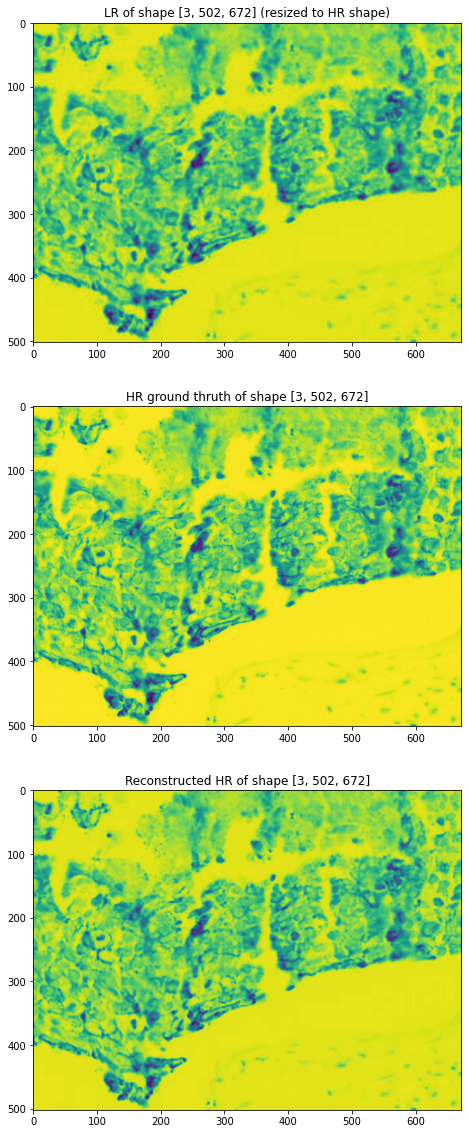

In [24]:
plot_3_images(lr_resized, trans1(trans(im_HR_gt.data)).numpy(), img_pred, (20,20))

##### Evaluate loss and error metrics:

Predicted HR (left) VS original HR (right)
MSE: 0.00068984, NMSE: 0.02960925, SSIM : 0.9382


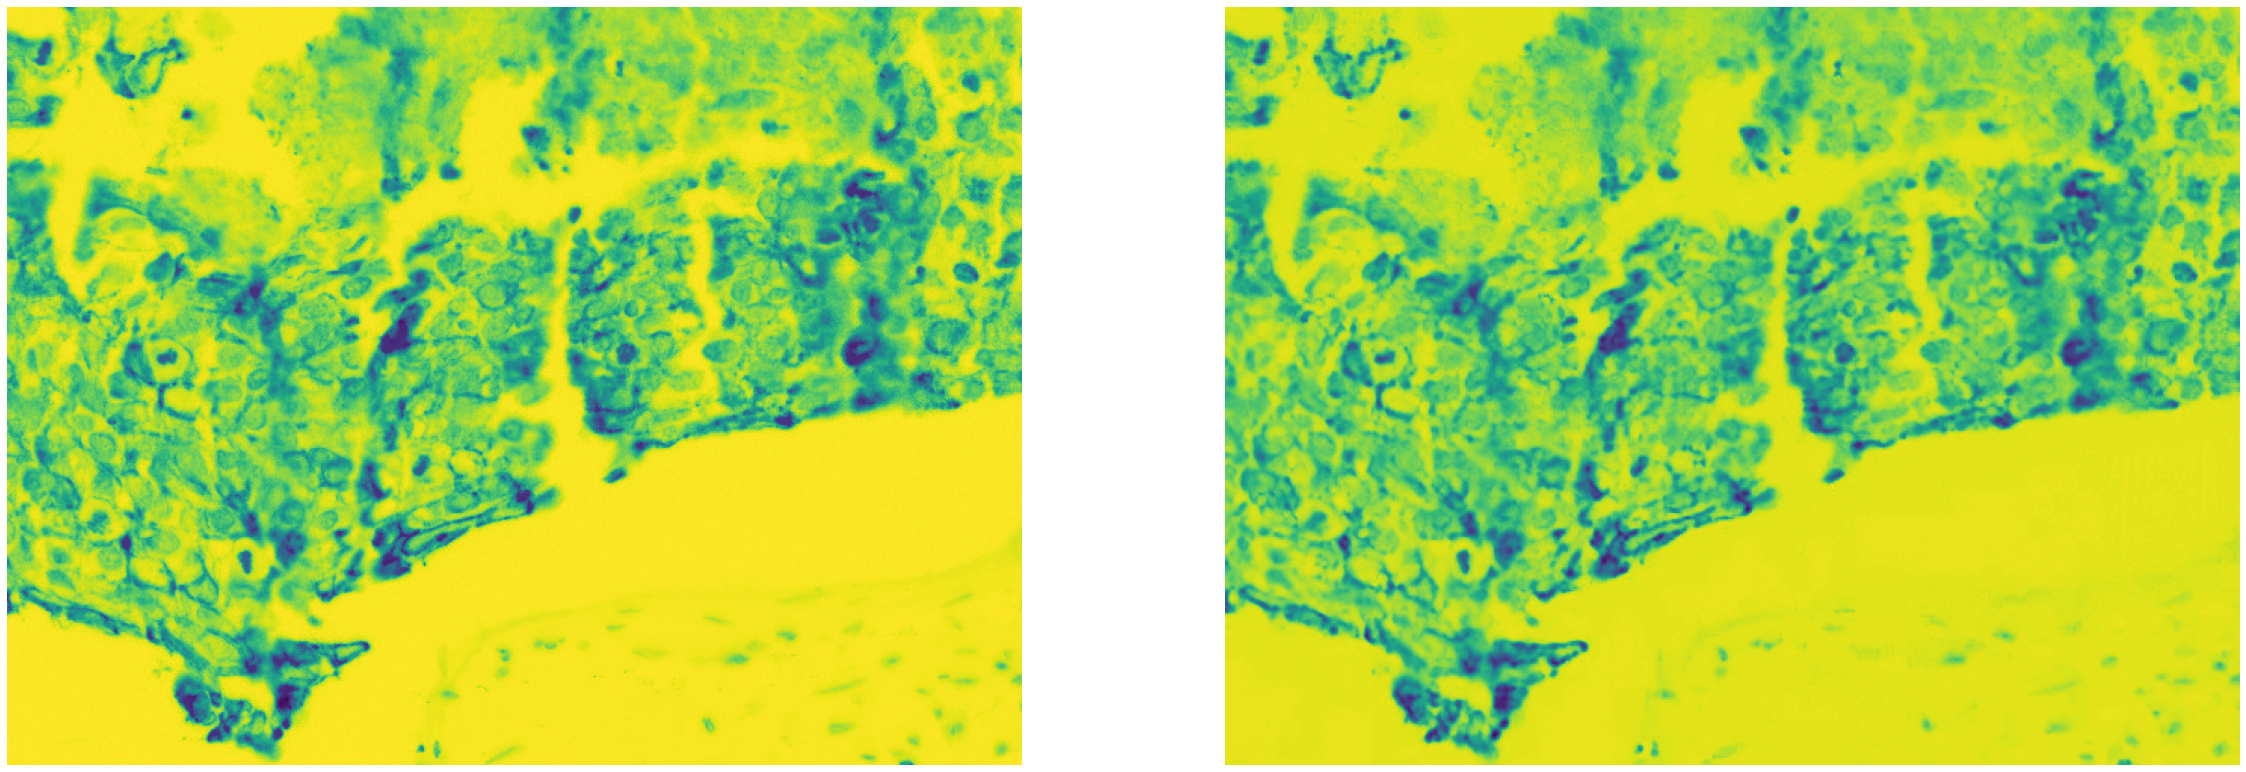

In [26]:
compare_images_metrics(trans1(trans(im_HR_gt.data)).numpy(), img_pred.numpy())

In [30]:
# Create test table with results:

test_files = []

with os.scandir(path_lr) as entries:
        test_files = [entry.name for entry in entries if entry.is_file()]
test_files = ['0126_[57372,9741]_part_3_-2.jpg',
 '0114_[43269,12680]_part_2_-5.jpg',
 '0116_[50508,7429]_part_2_-2.jpg',
 '0116_[47855,18651]_part_1_-2.jpg',
 '0126_[50247,10100]_part_1_-4.jpg',
 '0124_[43058,10798]_part_1_-2.jpg',
 '0116_[55600,10641]_part_4_-0.jpg',
 '0126_[52797,7360]_part_3_-2.jpg',
 '0015_[37778,13782]_part_4_-5.jpg']

def testing_images(test_files, path_lr, path_hr):
    MSE,NMSE, SSIM = [], [],[]

    for file in test_files:
        lr_data = open_image(path_lr/file)

        # resample to same size as HR:
        # for pytorch, have to add a first new dimension to indicate bs = 1
        # now lr_data of shape [1, 3, 250, 334]
        lr_data = lr_data.data.unsqueeze(0)
        lr_resized = torch.nn.functional.interpolate(lr_data, size_mr[1:],
                                                     mode='bicubic')
        # remove the previous added dimension
        lr_resized = lr_resized.squeeze()

        # corresponding ground truth HR: 
        im_HR_gt = open_image(path_hr/file)
        #print('HR ground thruth shape: {}'.format(list(im_HR_gt.shape)))

        # Prediction of model: 
        p, img_pred, b = learn.predict(Image(lr_resized))
        #print('Reconstructed HR shape: {}'.format(list(p.shape)))

        # Assert reconstructed HR has same shape as ground truth HR:
        assert(list(p.shape) == list(im_HR_gt.shape))

        gt_HR_nd = trans1(trans(im_HR_gt.data)).numpy()
        pred_HR_nd = img_pred.numpy()

        MSE.append(mse_mult_chann(gt_HR_nd, pred_HR_nd))
        NMSE.append(measure.compare_nrmse(gt_HR_nd, pred_HR_nd))
        SSIM.append(ssim_mult_chann(gt_HR_nd, pred_HR_nd))
    
    return pd.DataFrame(data = {'file':test_files, 'MSE':MSE, 'NMSE':NMSE, 'SSIM':SSIM})
      
testing_images(test_files, path_lr, path_hr)

file       MSE      NMSE      SSIM
0   0126_[57372,9741]_part_3_-2.jpg  0.000510  0.023713  0.945118
1  0114_[43269,12680]_part_2_-5.jpg  0.000405  0.021145  0.962191
2   0116_[50508,7429]_part_2_-2.jpg  0.000455  0.022592  0.966789
3  0116_[47855,18651]_part_1_-2.jpg  0.002434  0.051569  0.856918
4  0126_[50247,10100]_part_1_-4.jpg  0.000852  0.030626  0.928841
5  0124_[43058,10798]_part_1_-2.jpg  0.002409  0.051339  0.818375
6  0116_[55600,10641]_part_4_-0.jpg  0.000437  0.022415  0.965080
7   0126_[52797,7360]_part_3_-2.jpg  0.000437  0.022590  0.963114
8  0015_[37778,13782]_part_4_-5.jpg  0.000637  0.026896  0.914518